In [11]:
import os, sys, time, datetime, random
import numpy as np
import matplotlib as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torch.autograd import Variable
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm


from PIL import Image

In [49]:
print(torch.cuda.device(0))
print(torch.cuda.device_count())

print(torch.cuda.is_available())

0
False


In [13]:
def bbox_iou(box1, box2, x1y1x2y2=True):
        """
        Returns the IoU of two bounding boxes
        """
        if not x1y1x2y2:
            # Transform from center and width to exact coordinates
            b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
            b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
            b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
            b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
        else:
            # Get the coordinates of bounding boxes
            b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
            b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = torch.max(b1_x1, b2_x1)
        inter_rect_y1 = torch.max(b1_y1, b2_y1)
        inter_rect_x2 = torch.min(b1_x2, b2_x2)
        inter_rect_y2 = torch.min(b1_y2, b2_y2)
        # Intersection area
        inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
            inter_rect_y2 - inter_rect_y1 + 1, min=0
        )
        # Union Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

        iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

        return iou
    

In [14]:
class utils:
    def load_classes(path):
        """
        Loads class labels at 'path'
        """
        fp = open(path, "r")
        names = fp.read().split("\n")[:-1]
        return names
    
    
    def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
        """
        Removes detections with lower object confidence score than 'conf_thres' and performs
        Non-Maximum Suppression to further filter detections.
        Returns detections with shape:
            (x1, y1, x2, y2, object_conf, class_score, class_pred)
        """
        # From (center x, center y, width, height) to (x1, y1, x2, y2)
        box_corner = prediction.new(prediction.shape)
        box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
        box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
        box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
        box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
        prediction[:, :, :4] = box_corner[:, :, :4]

        output = [None for _ in range(len(prediction))]
        for image_i, image_pred in enumerate(prediction):
            # Filter out confidence scores below threshold
            conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
            image_pred = image_pred[conf_mask]
            # If none are remaining => process next image
            if not image_pred.size(0):
                continue
            # Get score and class with highest confidence
            class_conf, class_pred = torch.max(image_pred[:, 5 : 5 + num_classes], 1, keepdim=True)
            # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
            detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
            # Iterate through all predicted classes
            unique_labels = detections[:, -1].cpu().unique()
            if prediction.is_cuda:
                unique_labels = unique_labels.cuda()
            for c in unique_labels:
                # Get the detections with the particular class
                detections_class = detections[detections[:, -1] == c]
                # Sort the detections by maximum objectness confidence
                _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
                detections_class = detections_class[conf_sort_index]
                # Perform non-maximum suppression
                max_detections = []
                while detections_class.size(0):
                    # Get detection with highest confidence and save as max detection
                    max_detections.append(detections_class[0].unsqueeze(0))
                    # Stop if we're at the last detection
                    if len(detections_class) == 1:
                        break
                    # Get the IOUs for all boxes with lower confidence
                    ious = bbox_iou(max_detections[-1], detections_class[1:])
                    # Remove detections with IoU >= NMS threshold
                    detections_class = detections_class[1:][ious < nms_thres]

                max_detections = torch.cat(max_detections).data
                # Add max detections to outputs
                output[image_i] = (
                    max_detections if output[image_i] is None else torch.cat((output[image_i], max_detections))
                )

        return output
    def parse_model_config(path):
        """Parses the yolo-v3 layer configuration file and returns module definitions"""
        file = open(path, 'r')
        lines = file.read().split('\n')
        lines = [x for x in lines if x and not x.startswith('#')]
        lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
        module_defs = []
        for line in lines:
            if line.startswith('['): # This marks the start of a new block
                module_defs.append({})
                module_defs[-1]['type'] = line[1:-1].rstrip()
                if module_defs[-1]['type'] == 'convolutional':
                    module_defs[-1]['batch_normalize'] = 0
            else:
                key, value = line.split("=")
                value = value.strip()
                module_defs[-1][key.rstrip()] = value.strip()

        return module_defs

    def parse_data_config(path):
        """Parses the data configuration file"""
        options = dict()
        options['gpus'] = '0,1,2,3'
        options['num_workers'] = '10'
        with open(path, 'r') as fp:
            lines = fp.readlines()
        for line in lines:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            key, value = line.split('=')
            options[key.strip()] = value.strip()
        return options



In [15]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list

In [16]:
class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


In [17]:
class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()

In [18]:
class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size
                
    def to_cpu(tensor):
        return tensor.detach().cpu()    

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss




In [19]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = utils.parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)
     
    def to_cpu(tensor):
        return tensor.detach().cpu()

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        #yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        yolo_outputs = torch.cat(yolo_outputs, 1)
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

In [20]:
#Pre-trained Darknet/YOLO configurations and weights 
#and class names can be downloaded on (follow instructions): https://pjreddie.com/darknet/yolo/
config_path ='/home/zexcalibur/darknet/cfg/yolov3.cfg'
weights_path='/home/zexcalibur/darknet/yolov3.weights'
class_path  ='/home/zexcalibur/darknet/data/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.load_darknet_weights(weights_path)
#model.cuda()
model.eval()
classes = utils.load_classes(class_path)
dtype = torch.FloatTensor
#Tensor = torch.cuda.FloatTensor
#Tensor = torch.tensor(tmp, requires_grad=False, dtype=torch.float64)


In [21]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])    
    # convert image to Tensor    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)    
    #problem here - fixed
    input_img = Variable(image_tensor.type(dtype), requires_grad=True)
    
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    
    #print("detections done!")
    return detections[0]

Inference Time: 0:00:00.691543
List of bounding boxes:  [[62, 64, 195, 97], [233, 22, 301, 177], [375, 97, 141, 69], [200, 107, 133, 52]]
# of detections:  4


<Figure size 432x288 with 0 Axes>

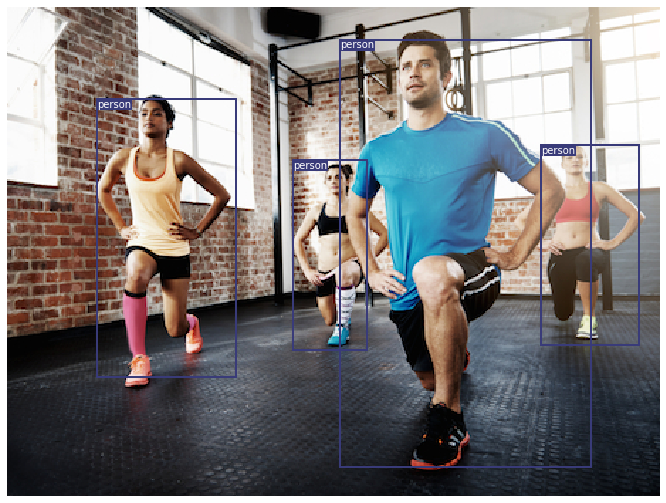

In [48]:
# load image and get detections
img_path = "/home/work/1.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

box_list = []

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels) #number of classes predicted    
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:        
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]        
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')        
        #Adds visisble bounding box to image
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})         
        crop_areas = [int(x1), int(y1), int(box_h), int(box_w)]
        box_list.append(crop_areas)
        
        #print("Predicted class(es): ", classes[int(cls_pred)], )

print("List of bounding boxes: ", box_list)

plt.axis('off')
#####################################
# crops each detection individually #
# and saves them to new file        #
#####################################
for i in range(len(detections)):
    for box in (box_list):
        box = box_list[i]
        x,y,h,w = box
        cropped_img = img[y:y+h, x:x+w, :]        
        filename = os.path.splitext(img_path)[0]
        ext = os.path.splitext(img_path)[1]
        new_filename = filename + '_'+ str(i) + ext 
        # save image
    plt.imsave(new_filename, cropped_img, cmap='Greys')
    
    
    
    
    
    
print("# of detections: ", len(detections)) 